<a href="https://colab.research.google.com/github/kiryu-3/Prmn2023/blob/main/Python/Python_Machine/Machine_Learning_3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 機械学習モデルの精度の測り方-知識編

In [ ]:
# 最初にインポートしてください
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import PolynomialFeatures

## 汎化性能

学習データだけでなく未知のデータに対しても正しく予測できる性能のことを、  
**汎化性能**といいます。

汎化性能が高いモデルは、**過学習**が起きにくくなります。

これらの事項のことは、[カメさんの記事](https://datawokagaku.com/holdout/#i)が参考になります。

### hold-out法

手元にあるデータセットを学習用とテスト用の二つに分ける手法を**hold-out法**といいます。

**学習データ**のみでモデルを構築し、  
**テストデータ**（未知のデータとする）で汎化性能を測ります。

ここでは登場していない**検証データ**は、モデルのパラメータの調整に使われます。

テストデータはあくまでも最終的な精度を測るためのものとし、途中の精度の評価は検証データに任せることで、  
過学習を抑えることができます。

これらの事項のことは、[カメさんの記事](https://datawokagaku.com/holdout/#1_hold-out)が参考になります。

###  LOOCV

LOOCV(Leave-One-Out Cross Validation)では、手元のデータのうち、  
一つだけをテストデータとして他の全てを学習データとします。

ひとつ以外の全てのデータで学習をしてモデルを作って、そのモデルをたったひとつのデータで評価します。  
この作業をデータの数だけ行います（すべてのデータをテストデータになるようにする）。

図に表すと以下のような感じです。  
（参考：https://shorturl.at/koCDP ）

![](https://imgur.com/MFieQ70.png)

ほぼ全てのデータを学習データとして使うことができるので、  
手元にあるデータを無駄なく使用することができます。

また、hold-outとは違い、ランダム性はなく最終的な精度の評価は常に同じになります。

#### hold-outとLOOCVの比較

以下に描画したデータで、hold-outとLOOCVを比較してみます。  
（正弦関数にノイズを加えたデータ）

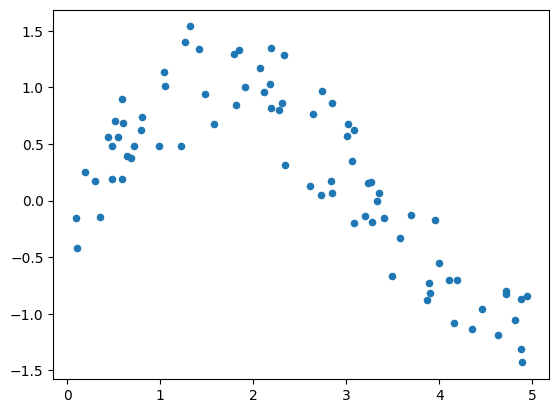

In [ ]:
# ランダムなデータ生成
np.random.seed(0)
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel() + np.random.normal(0, 0.3, X.shape[0])

# プロット
plt.scatter(X, y, s=20, label='Data')

まずはhold-outです。  
残差の二乗の平均（MSE）を使って精度を測ります。

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# evaluate
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

0.3204128619961065

次はLOOCVです。  
同じく、残差の二乗の平均（MSE）を使って精度を測ります。

In [ ]:
# cross_val_score関数を使えば簡単にCVを実行可能
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
cv = LeaveOneOut()
scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
print(f"MSE(LOOCV):{-np.mean(scores)}")
print(f"std:{np.std(scores)}")

MSE(LOOCV):0.3283640221742444
std:0.39772340287316765


変数`scores`には、80回MSEを計算した結果が入っています。  
平均をとると、hold-outに比べて少しだけ値が大きくなりました。

In [ ]:
scores

array([-1.53111915e+00, -2.29205491e+00, -6.09304719e-01, -6.63691684e-01,
       -1.26297502e+00, -1.32089505e-01, -5.34555751e-01, -1.81732662e-01,
       -3.38892772e-02, -1.01073634e-01, -1.98169968e-03, -4.74997938e-01,
       -2.97136339e-02, -2.08480620e-01, -2.11073427e-01, -1.15032449e-01,
       -2.86693986e-02, -1.85911929e-03, -5.86553645e-02, -2.01287274e-01,
       -1.03292531e-01, -2.52883027e-02, -6.36935815e-01, -9.17966476e-01,
       -6.22655698e-01, -1.64492801e-01, -2.95389831e-02, -7.59439542e-01,
       -1.84842421e-01, -8.59664271e-01, -3.86381383e-01, -7.14375709e-01,
       -4.22071549e-01, -5.51437767e-01, -2.81321946e-01, -1.14226562e+00,
       -2.92471951e-01, -3.79434865e-01, -1.11918223e+00, -5.21882451e-03,
       -4.36723440e-04, -4.11161526e-01, -2.91866449e-03, -7.78038867e-01,
       -1.17362173e-02, -3.16666718e-05, -6.59821968e-01, -3.30665229e-01,
       -4.70771671e-01, -1.36789069e-01, -3.39218056e-02, -4.32362402e-01,
       -6.27162133e-03, -

#### LOOCVの欠点

LOOCVには、**非常にコストがかかる**という欠点があります。  

データ数が多い場合や、一つのモデルを構築するのに時間がかかる場合は  
現実的ではありません。

### k-Fold Cross Validation

k-Fold Cross Validation（k-Fold交差検証）は、hold-outとLOOCVの中間的な手法です。  
実際の業務では最も使われる汎化性能の測定手法のようです。

k-Fold Cross Validationは、手元のデータをk個のグループに分割して、  
k個のうちひとつのグループをテストデータとして、残りのデータを学習データとします。

それを全てのグループがテストデータになるようk回繰り返します。

図に表すと以下のような感じです。  
（参考：https://shorturl.at/koCDP ）

![](https://imgur.com/OKbLt2J.png)

データを5分割して、それぞれのグループをテストデータ、  
それ以外のデータを学習データにしてモデルを構築し精度を測ります。

これを5回繰り返すので5つの結果がでます。  
それを平均した値を最終的な精度の結果とします。

#### k-Fold CVの実装

In [ ]:
from sklearn.model_selection import KFold, RepeatedKFold
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=0)
scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
print(f"MSE({k}FoldCV): {-np.mean(scores)}")
print(f"std: {np.std(scores)}")

MSE(5FoldCV): 0.32945649960710216
std: 0.08663082566094932


In [ ]:
scores

array([-0.31287082, -0.33157918, -0.44127452, -0.38078558, -0.18077239])

よく使われるのは**k=5**と**k=10**のようです。

#### Repeated k-Fold CV

k-Fold CVの際のグループ分けはランダムに行われるので、実行するたびに評価値は変化します。

そのため、k-Fold CVを何回か行い、すべての平均を取ることで  
よりランダム性を排除して精度の評価を行うことができます。

以下のコードでは、データを5つのグループに分けて、  
それぞれのグループをテストデータとして学習させる処理を行っています。

グループ分けを3回繰り返すことで、計15回の学習・評価を行うことになります。

In [ ]:
# データを5つのグループに分ける
k = 5

# 3回グループ分けを行う
n_repeats = 3

# 15回学習を行う
cv = RepeatedKFold(n_splits=k, n_repeats=n_repeats, random_state=0)

# 15回分MSEを求める
scores = cross_val_score(model, X, y, cv=cv, scoring='r2')

# MSEの平均と標準偏差を求める
print(f"R2({k}FoldCV): {np.mean(scores)}")
print(f"std: {np.std(scores)}")

MSE(5FoldCV): 0.3239604038024636
std: 0.0758961988723844


In [ ]:
scores

array([-0.31287082, -0.33157918, -0.44127452, -0.38078558, -0.18077239,
       -0.34617531, -0.22898302, -0.40298118, -0.20351565, -0.41348086,
       -0.29918205, -0.25180391, -0.34250117, -0.38847282, -0.33502759])

引数`scoring`の値を変えると、ほかの評価指標を使うことができます。

- **MSE**：'neg_mean_squared_error'
- **MAE**：'neg_mean_absolute_error'
- **RMSE**：直接はサポートされていない（MSEの平方根を取る）
- **決定係数**：'r2'

## 回帰モデルの評価指標

回帰モデルでよく使われる評価指標についてまとめます。

以下の線形回帰モデルの評価を行います。

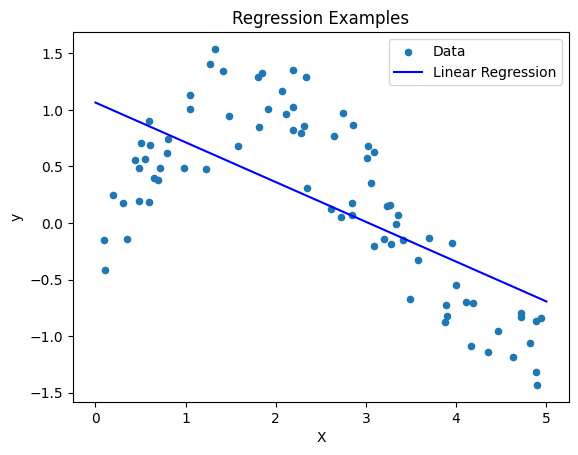

In [ ]:
# ランダムなデータ生成
np.random.seed(0)
X = np.sort(5 * np.random.rand(80, 1), axis=0)
y = np.sin(X).ravel() + np.random.normal(0, 0.3, X.shape[0])

# プロット用のデータ
X_plot = np.linspace(0, 5, 100)[:, np.newaxis]

# 直線回帰
linear_model = LinearRegression()
linear_model.fit(X, y)
y_linear_pred = linear_model.predict(X_plot)

# プロット
plt.scatter(X, y, s=20, label='Data')
plt.plot(X_plot, y_linear_pred, color='b', label='Linear Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Regression Examples')
plt.legend()
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### MSE

**MSE(Mean Squared Error)**は、残差の二乗の平均です。

二乗しているので、指標の解釈がしづらいという欠点があります。

$\hat{y}_i = \theta_1x_{i1} + \theta_2x_{i2} + … + \theta_nx_{in}$　のとき、

$$
MSE = \frac{1}{m}\sum^{m}_{i=1}({y_i-\hat{y}_i)^2}
$$

In [ ]:
# evaluate
mean_squared_error(y_test, y_pred)

0.3204128619961065

### RMSE

**RMSE(Root Mean Squared Error)**は平方根をしたものになります。

目的変数の単位と一致しているので、解釈がしやすいという特徴があります。


$\hat{y}_i = \theta_1x_{i1} + \theta_2x_{i2} + … + \theta_nx_{in}$　のとき、

$$
RMSE=\sqrt{\frac{1}{m}\sum^{m}_{i=1}(y_i-\hat{y_i})^2}
$$

In [ ]:
# evaluate
mean_squared_error(y_test, y_pred, squared=False)

0.566050229216548

### MAE

**MAE(Mean Absolute Error)**は、残差の絶対値の平均になります。

MSEやRMSEに比べて、大きい残差の影響力が小さくなります。

$\hat{y}_i = \theta_1x_{i1} + \theta_2x_{i2} + … + \theta_nx_{in}$　のとき、

$$
MAE=\frac{1}{m}\sum^{m}_{i=1}|y_i-\hat{y_i}|
$$

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_pred)

0.49141489997720145

### 決定係数

「説明変数がどれだけ目的変数の値を説明しているかの指標」を**決定係数**といいます。

一般的に$R^2$で示され、0から1までの値をとります。  
1に近いほど、回帰式が実際のデータに当てはまっていることを表しています。

基準の目安は以下の通りです。  
（参考：https://istat.co.jp/ta_commentary/multiple_02 ）

* **0.8以上**：精度良い
* **0.5~0.8**：精度やや良い
* **0.5以下**：精度良くない


#### 決定係数の定義

![リンクテキスト](https://imgur.com/gsoWMOU.png)

①：全変動：実測値とデータ全体の平均値との差  
②：回帰変動：予測値とデータ全体の平均値との差  
③：残差変動：実測値と予測値との差

②の回帰変動は「回帰直線によって説明できた部分」、  
③の残差変動は「回帰直線によって説明できなかった部分」となります。

（[こちら](https://bit.ly/3XZs1IQ)などに書かれている証明によって）以下の式が成り立ちます。

$$
\sum (y_i-\bar{y})^2 = \sum(\hat{y}_i-\bar{y})^2 + \sum(y_i-\hat{y}_i)^2
$$



決定係数は「回帰変動が全変動に対してどれだけ多いか」を表すものなので、  
決定係数は回帰変動を全変動で割ることで求められます。

$$
R^2 = \frac{\sum(\hat{y}_i-\bar{y})^2}{\sum (y_i-\bar{y})^2} = 1-\frac{\sum(y_i-\hat{y}_i)^2}{\sum (y_i-\bar{y})^2}
$$

In [ ]:
print('訓練データに対する決定係数：', model.score(X_train, y_train))
print('テストデータに対する決定係数：', model.score(X_test, y_test))

訓練データに対する決定係数： 0.39273934181526227
テストデータに対する決定係数： 0.5214728434063867
